<a href="https://colab.research.google.com/github/MicheleUIT/Uncertainty/blob/master/Experiments_with_TF_Probability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TensorFlow Probability (rough notes)

This is a brief personal introduction to [TensorFlow Probability](https://www.tensorflow.org/probability/). I have found the current documentation to be confusing, so I skirmed a few tutorials and guides and put together some notes. This notebook moves from defining a simple distribution to graphical models and training a Bayesian neural network with Variational Inference.

> 1. Current stable version of TFP is 0.13, this might change anytime, breaking this notebook. 
> 2. The documentation being confusing, this might have errors or things that could have been done better otherwise.
> 3. See at the end for a list of topics I still have not touched in these notes.

## Setup and imports

In [ ]:
%pip install --upgrade tensorflow-probability -qqq

In [ ]:
import numpy as np

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

## 1) Distributions

The core construct in TFP are Distribution objects. There are a lot of them already implemented, some of which are quite complex (e.g., PixelCNN):
https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Distribution

Manipulating distributions is probably the only thing that is documented extensively in the guides:
https://www.tensorflow.org/probability/examples/A_Tour_of_TensorFlow_Probability#distributions
https://www.tensorflow.org/probability/examples/Understanding_TensorFlow_Distributions_Shapes
https://www.tensorflow.org/probability/examples/TensorFlow_Distributions_Tutorial

In [ ]:
# Let us try a simple Multinomial distribution with N=10 trials and 3 possible outputs:
mn = tfp.distributions.Multinomial(10, [0.65, 0.05, 0.3])

In [ ]:
# There are basically two things we can do with distributions: sample and compute the probability of a sample (either normalized or unnormalized)
print(mn.sample())
print(mn.prob([2, 7, 1]))
print(mn.log_prob([2, 7, 1]))

tf.Tensor([4. 2. 4.], shape=(3,), dtype=float32)
tf.Tensor(0.0011263869, shape=(), dtype=float32)
tf.Tensor(-6.78874, shape=(), dtype=float32)


In [ ]:
# Inside a Distribution object, we can instantiate different distributions together (a "batch" of distributions)
# There are some pretty strange broadcasting effects: for example, these two multimonials distributions have a shared number of trials
mn_two = tfp.distributions.Multinomial(10, [[0.65, 0.05, 0.3], [0.35, 0.35, 0.3]])

In [ ]:
# Batch shape is how many distributions this represents
print(mn_two.batch_shape)
# Event shape is the shape of the single distribution
print(mn_two.event_shape)

(2,)
(3,)


In [ ]:
# Sampling from a distribution can also take a shape
x = mn_two.sample(5)

In [ ]:
# The final strange shape is: [sampling_shape] x [batch_shape] x [event_shape]
# This must be read as: 5 samplings from 2 multinomial distributions, whose event space is in R^3.
print(x.shape)

(5, 2, 3)


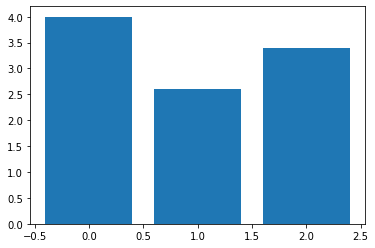

In [ ]:
# Plot an average of the 5 samples for the first multinomial distribution
_ = plt.bar([0,1,2], tf.reduce_mean(x[:, 0, :], axis=0))

In [ ]:
# We can "move" the batch dimension to the event dimension by considering the Independent distribution:
mn_two_ind = tfd.Independent(mn_two, reinterpreted_batch_ndims=1)

In [ ]:
# Now we have a single distribution, representing a draw from two independent multimonial distributions
print(mn_two_ind.batch_shape)
print(mn_two_ind.event_shape)

()
(2, 3)


In [ ]:
# If we need independent draws from the *same* distributions we can use instead Sample:
mn_two_draws = tfd.Sample(mn, sample_shape=(4,))
print(mn_two_draws.batch_shape)
print(mn_two_draws.event_shape) # 4 independent draws from the same multinomial distribution

()
(4, 3)


In [ ]:
# Somewhat confusingly, some distributions have trainable parameters, e.g.,
# a PixelCNN model is implemented inside tfp.distributions:
pixelcnn = tfp.distributions.PixelCNN((16, 16, 3), num_resnet=1, num_hierarchies=1, num_filters=10)

In [ ]:
len(pixelcnn.trainable_variables)

45

In [ ]:
# We can also add our own variables to standard distributions if we want to optimize them:
trainable_normal = tfd.Normal(loc=tf.Variable(0.0), scale=1.0)
print(trainable_normal.trainable_variables)

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>,)


## 2) Bijectors

Bijectors are diffeomorphisms (invertible & differentiable functions) between random variables. Given $x \sim p(x)$ and a bijection $z=f(x)$, then:

$$
p(z)=p(x)\lvert \text{det} J_{f^{-1}}(z) \rvert 
$$

where $J_{f^{-1}}$ is the Jacobian of the inverse transformation. Just like with distributions, TFP has a huge number of bijectors:
https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors

In [ ]:
# An half-normal distribution is obtained by taking the absolute value of a normal random variable:
folded_norm = tfd.HalfNormal(scale=1.0)

In [ ]:
# We can do the same by sampling from a normal distribution and then appling a bijection
norm = tfd.Normal(loc=0.0, scale=1.0)
bijection = tfb.AbsoluteValue()

In [ ]:
# We can use bijectors as functions applied on the samples
norm_samples = folded_norm.sample(1000)
folded_norm_samples = bijection(norm.sample(1000))

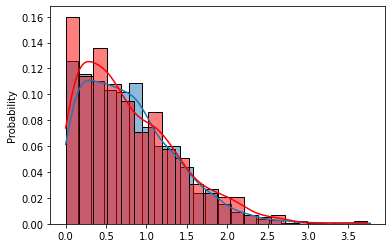

In [ ]:
sns.histplot(x=norm_samples, kde=True, stat='probability')
sns.histplot(x=folded_norm_samples, kde=True, color='red', stat='probability')

In [ ]:
# Bijectors also implement the logic to compute the inverse and/or the log determinant of the Jacobian (forward or inverse)
print(bijection.inverse([0.2])) # This is a set inverse returning -0.2 and 0.2
print(bijection.inverse_log_det_jacobian(0.2)) # 0 because this is the log of 1 (the actual derivative)

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.2], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)


In [ ]:
# With a Distribution and a Bijector, we can define a TransformedDistribution to avoid applying the bijector manually
half_norm = tfd.TransformedDistribution(norm, bijection)

In [ ]:
# Some distributions provide a default bijection to map a real to their support
folded_norm.experimental_default_event_space_bijector()

<tfp.bijectors.Softplus 'softplus' batch_shape=[] forward_min_event_ndims=0 inverse_min_event_ndims=0 dtype_x=? dtype_y=?>

In [ ]:
# We can use bijectors to parameterize unconstrained variables during optimization
positive_variable = tfp.util.TransformedVariable(1., bijector=tfb.Exp()) # Variable constrained to be positive
print(tfd.Normal(loc=0.0, scale=positive_variable).trainable_variables)

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>,)


In [ ]:
# One important bijection is the reshaping operation.
# Differently from tf.reshape, we need to specify the input shape to ensure invertibility.
tfb.Reshape((6,), event_shape_in=(2, 3))(mn_two_ind).event_shape

TensorShape([6])

In [ ]:
# We can also chain together bijections with Chain:
# https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Chain
complex_bijectors = tfb.Chain([
        tfb.AbsoluteValue(),
        tfb.Power(3)
])

In [ ]:
# Again, several bijectors are incredibly complex, notably TFP implements several state-of-the-art normalizing flows including NAFs.
# See here for an introduction to normalizing flows: https://arxiv.org/abs/1912.02762
# These are basically "trainable" biijectors implemented with neural networks.
normalizing_flow = tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=lambda y: (y, y + 1.))

## 3) Layers

Layers can be used to "plug-in" probabilistic layers inside TensorFlow models. There are many predefined layers, notably to perform variational inference (see below):
https://www.tensorflow.org/probability/api_docs/python/tfp/layers

In [ ]:
def load_iris():
  # Simple function to load the Iris dataset
  # Note: we are performing a little bit of label smoothing to avoid numerical issues below (I am sure there is a better way, but this is just a toy notebook)
  iris_train, iris_test = tensorflow_datasets.load('iris', split=['train[:70%]', 'train[70%:]'], as_supervised=True)
  X_train, y_train = next(iter(iris_train.batch(10000)))
  X_test, y_test = next(iter(iris_test.batch(10000)))
  y_train = tf.cast(tf.one_hot(y_train, 3, on_value=0.99, off_value=0.01), tf.float32)
  y_test = tf.cast(tf.one_hot(y_test, 3, on_value=0.99, off_value=0.01), tf.float32)
  return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = load_iris()

In [ ]:
# Normalization layer for the input
norm = keras.layers.Normalization()
norm.adapt(X_train)

In [ ]:
# The 'RelaxedOneHotCategorical' is a powerful way to approximate categorical distributions,
# also known as Gumbel-Softmax or Concrete distribution.
dist = tfd.RelaxedOneHotCategorical(logits=[1.0, -2.0], temperature=1.0)
print(dist.sample(2))

tf.Tensor(
[[0.9353895  0.06461043]
 [0.91769886 0.08230121]], shape=(2, 2), dtype=float32)


In [ ]:
# This is important: because the layer is reparameterized, TensorFlow is able
# to compute its gradients automatically.
print(dist.reparameterization_type)

<Reparameterization Type: FULLY_REPARAMETERIZED>


In [ ]:
# In order to insert it into a model, we wrap it into a DistributionLambda object (similar to a standard Lambda layer).
# The layer samples during the forward pass, and compute the gradients as per above in the backward pass.
gumbel_softmax = tfp.layers.DistributionLambda(lambda logits: tfd.RelaxedOneHotCategorical(logits=logits, temperature=1.0))

In [ ]:
# Standard fully-connected model, but we add our Gumbel-Softmax model at the end
model = keras.Sequential([
            keras.layers.Input((4,)), 
            norm, 
            keras.layers.Dense(10, activation='relu'),
            keras.layers.Dense(3),
            gumbel_softmax
    ])

In [ ]:
# Calling the model now returns a fully-fledged distribution!
model(X_train[0:1])

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[3] dtype=float32>

In [ ]:
# We can sample the output distribution to get multiple predictions, and then compute, e.g., some form of uncertainty.
print(model(X_train[0:1]).sample(3))

tf.Tensor(
[[[0.14498408 0.5651511  0.2898648 ]]

 [[0.06450069 0.2869705  0.6485289 ]]

 [[0.09284285 0.05383902 0.85331815]]], shape=(3, 1, 3), dtype=float32)


In [ ]:
# Because our model is now probabilitic, we can optimize by directly minimizing the negative log-likelihood:
negloglik = lambda y, rv_y: - rv_y.log_prob(y)

In [ ]:
# Optimization is standard, except that we minimize the negative log-likelihood defined above.
model.compile(loss=negloglik,
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])
model.fit(X_train, y_train, epochs=500, verbose=1)
model.evaluate(X_test, y_test)

## 4) Joint distributions

Joint distributions are the most sophisticated construct in TFP, because they allow to define graphical models easily:
https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/JointDistribution

Consider this completely meaningless graphical model, where I stitched together a few casually chosen distributions:

$$
a \sim \text{HalfCauchy}(0.0, 1.0) \\
b \sim \text{Exponential}(a) \\
c \sim \text{Normal}(0.0, 10.0) \\
d_i \sim \text{Normal}(c, b) \,, i = 1,2
$$

In [ ]:
# To implement the model in TFP, we can use a JointDistributionSequential, which works similarly to Sequential in TF.
# Each element can be a distribution (i.e., a root of the graphical model) or a callable. In the latter case,
# the arguments are ordered wrt the preceding elements in the model.
joint = tfd.JointDistributionSequential([
  tfp.distributions.HalfCauchy(loc=0.0, scale=1.0),
  lambda a: tfd.Exponential(a), # 'a' here is a sample from the HalfCauchy model
  tfd.Normal(loc=0., scale=10.),
  lambda mu, sigma: tfd.Sample(tfd.Normal(loc=mu, scale=sigma), 2), # 'mu' follows the Normal distribution above, 'sigma' the Exponential one
])

In [ ]:
# We can sample the full graphical model easily
joint.sample()

[<tf.Tensor: shape=(), dtype=float32, numpy=0.85623866>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.48505706>,
 <tf.Tensor: shape=(), dtype=float32, numpy=6.472289>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([6.979861 , 6.2074776], dtype=float32)>]

In [ ]:
# Get a simple graphical depiction to visualize everything is working correctly
joint.resolve_graph()

(('a', ()), ('sigma', ('a',)), ('mu', ()), ('x', ('mu', 'sigma')))

In [ ]:
# Log prob of the entire model
joint.log_prob(joint.sample())

<tf.Tensor: shape=(), dtype=float32, numpy=-4.6552863>

In [ ]:
# Divided by parts
joint.log_prob_parts(joint.sample())

[<tf.Tensor: shape=(), dtype=float32, numpy=-6.8910875>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.887125>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-3.2886708>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.6885324>]

In [ ]:
# Alternatively, we can get samples and corresponding distributions
joint.sample_distributions()

([<tfp.distributions.HalfCauchy 'HalfCauchy' batch_shape=[] event_shape=[] dtype=float32>,
  <tfp.distributions.Exponential 'Exponential' batch_shape=[] event_shape=[] dtype=float32>,
  <tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>,
  <tfp.distributions.Sample 'SampleNormal' batch_shape=[] event_shape=[2] dtype=float32>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=0.9708817>,
  <tf.Tensor: shape=(), dtype=float32, numpy=0.14014971>,
  <tf.Tensor: shape=(), dtype=float32, numpy=-0.058480423>,
  <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.12430605, -0.11886838], dtype=float32)>])

In [ ]:
# We can "pin" some of the observed values
joint.experimental_pin(a=[0.5])

<tfp.distributions.JointDistributionPinned 'PinnedJointDistributionSequential' batch_shape=[[], [], []] event_shape=[[], [], [2]] dtype=[float32, float32, float32]>

In [ ]:
# Alternative way to sample a subportion of the model
joint.sample(a=[0.5])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2649266], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-8.288429>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-8.409351, -8.304682]], dtype=float32)>]

In [ ]:
# We can also define joint distributions by using dictionaries or generators, to better control naming and flow:
# https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/JointDistributionNamed
# https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/JointDistributionCoroutine

In [ ]:
# If we need to do variational inference on the graphical model, we can obtain a surrogate posterior easily
surrogate_posterior = tfp.experimental.vi.build_factored_surrogate_posterior(
  event_shape=joint.event_shape_tensor(),)

In [ ]:
# This has trainable mean and variance for each node in the original graphical model, as expected
surrogate_posterior.trainable_variables

(<tf.Variable 'loc:0' shape=() dtype=float32, numpy=-1.2503314>,
 <tf.Variable 'scale:0' shape=() dtype=float32, numpy=-4.6001782>,
 <tf.Variable 'loc_0001:0' shape=() dtype=float32, numpy=1.3510035>,
 <tf.Variable 'scale_0001:0' shape=() dtype=float32, numpy=-4.6001782>,
 <tf.Variable 'loc_0002:0' shape=() dtype=float32, numpy=-1.5623857>,
 <tf.Variable 'scale_0002:0' shape=() dtype=float32, numpy=-4.6001782>,
 <tf.Variable 'loc_0003:0' shape=(2,) dtype=float32, numpy=array([ 0.10016888, -0.57581   ], dtype=float32)>,
 <tf.Variable 'scale_0003:0' shape=(2,) dtype=float32, numpy=array([-4.6001782, -4.6001782], dtype=float32)>)

## 5) Variational inference for Bayesian neural networks

We now try to solve a more complex task by approximating the posterior over a full Bayesian neural network with variational inference. This part is mostly taken from there:
https://www.tensorflow.org/probability/examples/Probabilistic_Layers_Regression#case_3_epistemic_uncertainty

In [ ]:
# We define a Normal prior over the weights of a Dense layer. The VariableLayer is used
# to ensure that the variables for training the prior are created during the first call.
def prior(kernel_size, bias_size=0, dtype=tf.float32):
  n = kernel_size + bias_size
  return keras.Sequential([
      tfp.layers.VariableLayer(n),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [ ]:
# We equivalently define a variational posterior with a mean-field approximation as above
# Note: prior and posterior are basically copy-pasted from the tutorial above.
def posterior(kernel_size, bias_size=0, dtype=tf.float32):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [ ]:
# We now extend our previous layer, by replacing the dense layers with their variational variant.
model = keras.Sequential([
            keras.layers.Input((4,)), 
            norm, 
            tfp.layers.DenseVariational(10, posterior, prior, activation='relu', kl_weight=1/X_train.shape[0]),
            tfp.layers.DenseVariational(3, posterior, prior, activation='relu', kl_weight=1/X_train.shape[0]),
            gumbel_softmax
    ])

In [ ]:
# Training is equivalent to before, except that we can now sample both the output & the weights of the network
model.compile(loss=negloglik,
              optimizer=keras.optimizers.Adam(0.01),
              metrics=[keras.metrics.CategoricalAccuracy()])
model.fit(X_train, y_train, epochs=1500, verbose=0)
model.evaluate(X_test, y_test)

2/2 [==============================] - 1s 8ms/step - loss: -5.6028 - categorical_accuracy: 0.8889


[-5.602771759033203, 0.8888888955116272]

## Things I did not cover

1. Hamiltonian Monte Carlo (almost all the guides in the TFP website go through an example of MCMC).
2. Gaussian Processes: https://www.tensorflow.org/probability/examples/Gaussian_Process_Latent_Variable_Model
3. Generalized Linear Models: https://www.tensorflow.org/probability/examples/Generalized_Linear_Models
4. Probabilistic processing of time series: https://www.tensorflow.org/probability/examples/STS_approximate_inference_for_models_with_non_Gaussian_observations